In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt 
import torchvision.transforms as T
    

In [2]:

LARGE_NUM = 1e9

In [3]:
from datasets import load_dataset,DatasetDict

ds = load_dataset("jonathan-roberts1/EuroSAT")

README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

(…)-00000-of-00001-26e80b6de2d4dca7.parquet:   0%|          | 0.00/88.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

In [4]:
split_ratio = 0.2
data_splits = ds['train'].train_test_split(test_size=split_ratio,seed=42)
ds=DatasetDict({
    'train':data_splits['train'],
    'validation':data_splits['test']
})
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 21600
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})


In [5]:
testpicture = ds['train'][5]['image']
width, height = testpicture.size
print(f"Dimensions: {width}x{height}")
rgb_values = testpicture.getpixel((0, 0))
print(f"RGB values of top-left pixel: {rgb_values}")
pixels = np.array(testpicture)

print("Pixel array shape:", pixels.shape)

Dimensions: 64x64
RGB values of top-left pixel: (48, 75, 94)
Pixel array shape: (64, 64, 3)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

For RGB images: (height, width, 3) (the last dimension represents the three color channels: Red, Green, and Blue).
For grayscale images: (height, width) (no color channels).Iterating Over Pixels: If you need to process each pixel individually, you can loop through image.getpixel((x, y)), but this can be slow. Using numpy for pixel manipulation is generally faster.

In [7]:
# NT-Xent Loss Implementation
def nt_xent(z: torch.Tensor, perm: torch.Tensor, tau: float) -> torch.Tensor:
    """
    Pairwise normalized temperature-scaled cross-entropy loss (NT-Xent)
    """
    # Normalize features
    features = F.normalize(z, dim=1)
    sim = features @ features.T  # Cosine similarity

    # Mask self-similarities by subtracting a large number
    sim.fill_diagonal_(-LARGE_NUM)

    # Scale by temperature
    sim /= tau

    # Cross-entropy loss
    return F.cross_entropy(sim, perm)

In [8]:
# Data Preparation (SimCLR-specific Dataset)
class SimCLRDataset(Dataset):
    """
    Dataset class for SimCLR
    """
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]

        # Generate two augmented views
        view1 = self.transform(image)
        view2 = self.transform(image)

        return view1, view2

In [9]:
def compute_mean_std(dataset):
    """
    Compute the mean and std for the given dataset.
    """
    transform = T.ToTensor()  # Convert images to PyTorch tensors
    mean = torch.zeros(3)  # For RGB channels
    std = torch.zeros(3)
    total_pixels = 0

    for sample in dataset:
        image = transform(sample['image'])  # Convert image to tensor
        total_pixels += image.size(1) * image.size(2)  # H x W
        mean += image.sum(dim=[1, 2])  # Sum over H and W for each channel
        std += (image ** 2).sum(dim=[1, 2])  # Sum of squares over H and W

    mean /= total_pixels  # Compute mean
    std = torch.sqrt(std / total_pixels - mean ** 2)  # Compute std

    return mean.tolist(), std.tolist()

In [11]:
mean, std = compute_mean_std(ds['train'])
print("Mean:", mean)
print("Std:", std)

Mean: [0.3440585732460022, 0.38018861413002014, 0.4077899754047394]
Std: [0.20264330506324768, 0.13694031536579132, 0.11556307226419449]


In [56]:
# DataLoader
simclr_transforms = T.Compose([
    T.RandomResizedCrop(size=64),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.2)],p=0.2),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    # T.Normalize(mean=[0.344, 0.380, 0.407], std=[0.203, 0.136, 0.114])
    #to ensure that the data stays around 0
])

size=64

euroSAT_transforms = T.Compose([
            T.RandomResizedCrop(size=(size, size), scale=(0.7, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.ColorJitter(brightness=0.2,contrast=0.2, saturation=0.2, hue=0.2),
            # T.RandomRotation(degrees=30),
            # T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
            T.ToTensor(),
            # T.Normalize(mean=mean, std=std)
])

small_test_transforms = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

# Reasons for keeping the above augmentations 
 - RandomResizedCrop - it forces the model to learn spatial invariance, even if parts of the image are cropped out, model should recognize it as the same instance.forces the model to focus on overall structure rather than specific regions.
 - RandomHorizontalFlip and RandomVerticalFlip- we don't want the model to rely much on directionality
 - ColorJitter - Simulates changes in lighting and color conditions. foreces the model to learn shape and structure instead of color.


In [57]:
test_image = ds['train'][8]['image']
v1 = simclr_transforms(test_image)
v2 = simclr_transforms(test_image)
view1 = euroSAT_transforms(test_image)
view2 = euroSAT_transforms(test_image)

v1i = T.ToPILImage()(v1)
v2i = T.ToPILImage()(v2)
view1i = T.ToPILImage()(view1)
view2i = T.ToPILImage()(view2)

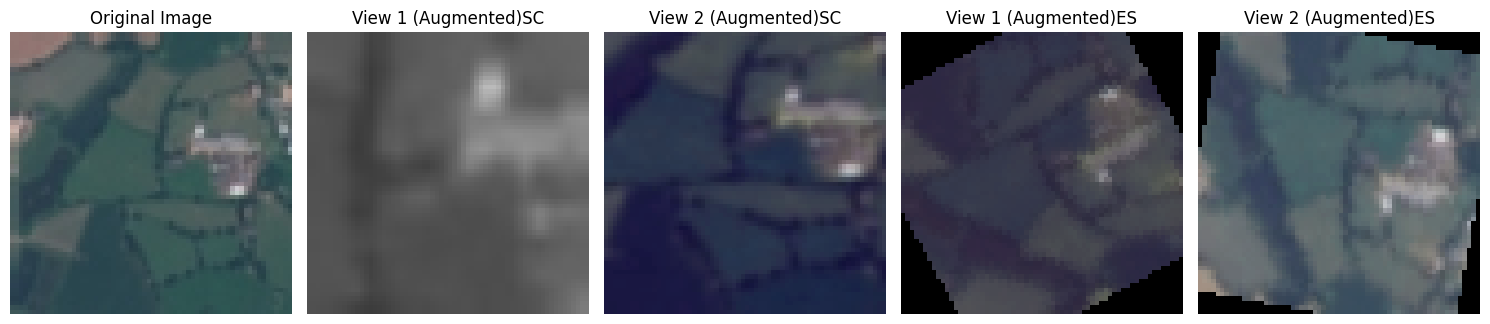

In [58]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(test_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(v1i)
axes[1].set_title("View 1 (Augmented)SC")
axes[1].axis("off")

axes[2].imshow(v2i)
axes[2].set_title("View 2 (Augmented)SC")
axes[2].axis("off")

axes[3].imshow(view1i)
axes[3].set_title("View 1 (Augmented)ES")
axes[3].axis("off")

axes[4].imshow(view2i)
axes[4].set_title("View 2 (Augmented)ES")
axes[4].axis("off")

plt.tight_layout()
plt.show()

In [15]:
# SimCLR Module
class SimCLR(nn.Module):
    """
    SimCLR Implementation with NT-Xent loss
    """
    def __init__(self, backbone: nn.Module, tau: float, feat_dim: int = 256):
        super(SimCLR, self).__init__()
        self.backbone = backbone
        self.tau = tau

        # Define the projection head
        z_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove the classification head
        self.projection_head = nn.Sequential(
            nn.Linear(z_dim, z_dim, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(z_dim, feat_dim, bias=False)
        )

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for two augmented views of the same image
        """
        b = x1.size(0)

        
        xp = torch.cat((x1, x2))  # (2b, c, h, w)

        # Permutation for positive pairs
        perm = torch.cat((torch.arange(b) + b, torch.arange(b)), dim=0).to(x1.device)

        h = self.backbone(xp)  # (2b, z_dim)
        z = self.projection_head(h)  # (2b, feat_dim)

        return nt_xent(z, perm, tau=self.tau)

In [16]:


train_dataset = SimCLRDataset(ds['train'],transform=euroSAT_transforms)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataset = SimCLRDataset(ds['validation'],transform=euroSAT_transforms)
val_loader = DataLoader(val_dataset,batch_size=1024,shuffle=False)


backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = SimCLR(backbone=backbone, tau=0.1).to(device)
model.load_state_dict(torch.load('/kaggle/input/simclr_model2/pytorch/v1/1/simclr_model2.pth',weights_only=True))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


In [31]:
# subset_indices = list(range(100))
# small_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
# small_loader = DataLoader(small_dataset, batch_size=64, shuffle=True)

In [32]:
# model.train()
# for epoch in range(100):  # Fewer epochs for overfitting test
    
#     epoch_loss = 0
#     for step, (x1, x2) in enumerate(small_loader):
#         x1, x2 = x1.to(device), x2.to(device)
#         loss = model(x1, x2)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     print(f"Tiny Dataset Epoch [{epoch + 1}/100], Loss: {epoch_loss:.4f}")

Tiny Dataset Epoch [1/100], Loss: 0.3625
Tiny Dataset Epoch [2/100], Loss: 0.3879
Tiny Dataset Epoch [3/100], Loss: 0.5519
Tiny Dataset Epoch [4/100], Loss: 0.4206
Tiny Dataset Epoch [5/100], Loss: 0.4685
Tiny Dataset Epoch [6/100], Loss: 0.3737
Tiny Dataset Epoch [7/100], Loss: 0.3681
Tiny Dataset Epoch [8/100], Loss: 0.2914
Tiny Dataset Epoch [9/100], Loss: 0.2740
Tiny Dataset Epoch [10/100], Loss: 0.2184
Tiny Dataset Epoch [11/100], Loss: 0.2192
Tiny Dataset Epoch [12/100], Loss: 0.1482
Tiny Dataset Epoch [13/100], Loss: 0.3492
Tiny Dataset Epoch [14/100], Loss: 0.1983
Tiny Dataset Epoch [15/100], Loss: 0.2754
Tiny Dataset Epoch [16/100], Loss: 0.1497
Tiny Dataset Epoch [17/100], Loss: 0.2096
Tiny Dataset Epoch [18/100], Loss: 0.3958
Tiny Dataset Epoch [19/100], Loss: 0.1387
Tiny Dataset Epoch [20/100], Loss: 0.3091
Tiny Dataset Epoch [21/100], Loss: 0.1397
Tiny Dataset Epoch [22/100], Loss: 0.1690
Tiny Dataset Epoch [23/100], Loss: 0.1611
Tiny Dataset Epoch [24/100], Loss: 0.1803
T

In [33]:
# epochs = 100
# for epoch in range(epochs):
#     model.train()
#     epoch_loss = 0
#     for step, (x1, x2) in enumerate(train_loader):
#         x1, x2 = x1.to(device), x2.to(device)
#         loss = model(x1, x2)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for step,(x1,x2) in enumerate(val_loader):
#             x1,x2 = x1.to(device),x2.to(device)
#             loss = model(x1,x2)
#             val_loss += loss.item()
#     print(f"Epoch [{epoch+1}/{epochs}], Validation Loss : {val_loss/len(val_loader):.4f}")

Epoch [1/100], Loss: 0.9695
Epoch [1/100], Validation Loss : 0.8169
Epoch [2/100], Loss: 0.7776
Epoch [2/100], Validation Loss : 0.7186
Epoch [3/100], Loss: 0.7203
Epoch [3/100], Validation Loss : 0.6772
Epoch [4/100], Loss: 0.6958
Epoch [4/100], Validation Loss : 0.6528
Epoch [5/100], Loss: 0.6706
Epoch [5/100], Validation Loss : 0.6458
Epoch [6/100], Loss: 0.6648
Epoch [6/100], Validation Loss : 0.6396
Epoch [7/100], Loss: 0.6489
Epoch [7/100], Validation Loss : 0.6290
Epoch [8/100], Loss: 0.6366
Epoch [8/100], Validation Loss : 0.6161
Epoch [9/100], Loss: 0.6321
Epoch [9/100], Validation Loss : 0.6152
Epoch [10/100], Loss: 0.6254
Epoch [10/100], Validation Loss : 0.6133
Epoch [11/100], Loss: 0.6151
Epoch [11/100], Validation Loss : 0.6087
Epoch [12/100], Loss: 0.6097
Epoch [12/100], Validation Loss : 0.5888
Epoch [13/100], Loss: 0.6094
Epoch [13/100], Validation Loss : 0.5956
Epoch [14/100], Loss: 0.6041
Epoch [14/100], Validation Loss : 0.5904
Epoch [15/100], Loss: 0.6103
Epoch [15

In [34]:
# import os
# save_dir = "/kaggle/working/"
# os.makedirs(save_dir, exist_ok=True)
# model_save_path = os.path.join(save_dir, "simclr_model2.pth")
# torch.save(model.state_dict(), model_save_path)

# print(f"Model saved to {model_save_path}")
# torch.save(model, os.path.join(save_dir, "simclr_full_model.pth"))

Model saved to /kaggle/working/simclr_model2.pth


In [15]:

print(f"Type of saved data: {type(model)}")
if isinstance(model, dict):
    print("Keys in the checkpoint:")
    print(model.keys())

    # If it has a `state_dict` key, inspect model weights
    if "state_dict" in model:
        print("Model state_dict keys:")
        print(model["state_dict"].keys())
else:
    print("Model or other saved object:")
    print(model)

Type of saved data: <class '__main__.SimCLR'>
Model or other saved object:
SimCLR(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [16]:
backbone 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

In [24]:
model.eval()
def extract_features(loader,model,device):
    features = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            images,targets = batch 
            images = images.to(device)
            embeddings = model.backbone(images)
            features.append(embeddings.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features,axis=0)
    labels = np.concatenate(labels,axis=0)
    return features,labels

In [25]:
features,labels = extract_features(val_loader,model,device)
labels = np.array(ds['validation']['label'])  # This should give a 1D array

In [26]:
print(f"Features shape: {features.shape}")  # Should be (num_samples, 2) for t-SNE
print(f"Labels shape: {labels.shape}")  

Features shape: (5400, 512)
Labels shape: (5400,)


In [27]:
tsne = TSNE(n_components = 2, perplexity = 30,random_state=42,n_iter=1000)
reduced_features = tsne.fit_transform(features)

In [28]:
def plot_tsne(features, labels, class_names):
    plt.figure(figsize=(10, 8))
    
    # Plot each class with a unique color
    for class_id in np.unique(labels):
        idx = (labels == class_id)  # Boolean mask
        plt.scatter(features[idx, 0], features[idx, 1], label=class_names[class_id], alpha=0.6, s=10)
    
    plt.legend()
    plt.title("t-SNE Visualization of SimCLR Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()


In [23]:
train_dataset = ds['train']
if hasattr(train_dataset.features['label'], 'names'):
    class_names = train_dataset.features['label'].names
    print(f"Class names: {class_names}")
else:
    print("No class names found. Labels might be integers.")

Class names: ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']


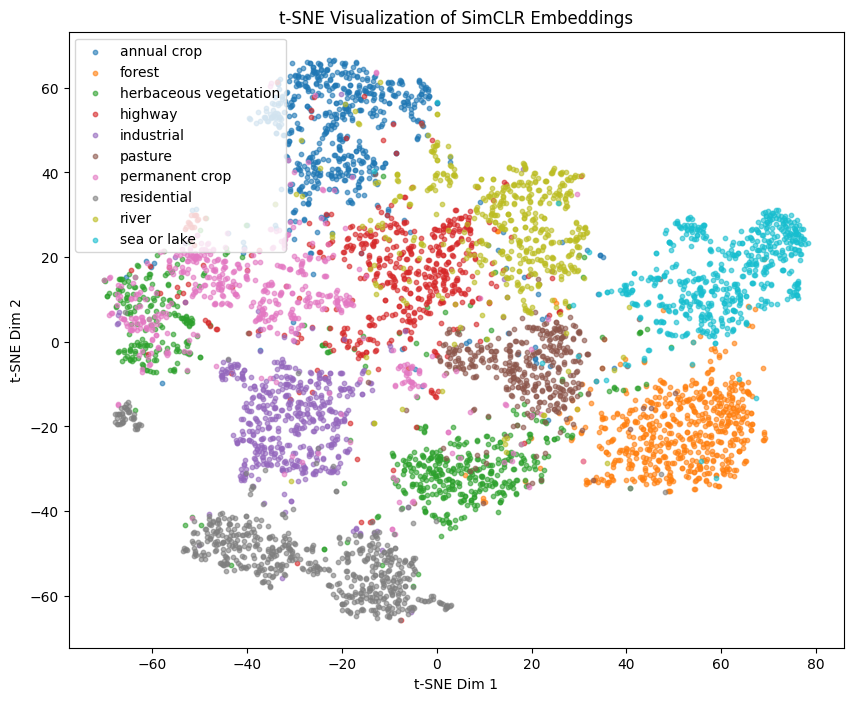

In [24]:
plot_tsne(reduced_features,labels,class_names)

## There's ambiguity when it comes to 
- herbaceous vegetation and permanent crop - maybe because the representations for these classes are not far apart ? 

- Is it possible that the augmentations are making some distinct classes look similar ?
-  For example is there any difference in texture between herbaceous vegetation and permanent crop 

- satellite images often emphasize channel specific information like vegetation indices like NDVI and stuff making grayscale less relevant for feature extraction. 

## What are the distinguishing features in ambiguous classes ?

6


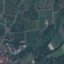

In [49]:
#Class names: ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']
print(ds['train'][78]['label'])
ds['train'][78]['image']

In [50]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 21600
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})

Samples from Herbaceous vegetation:


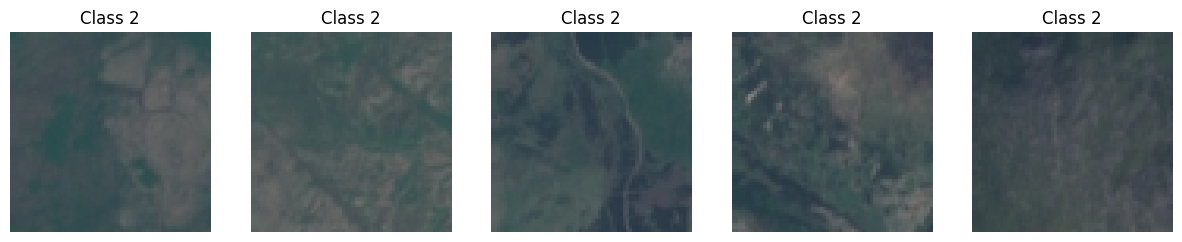

Samples from Permanent Crop


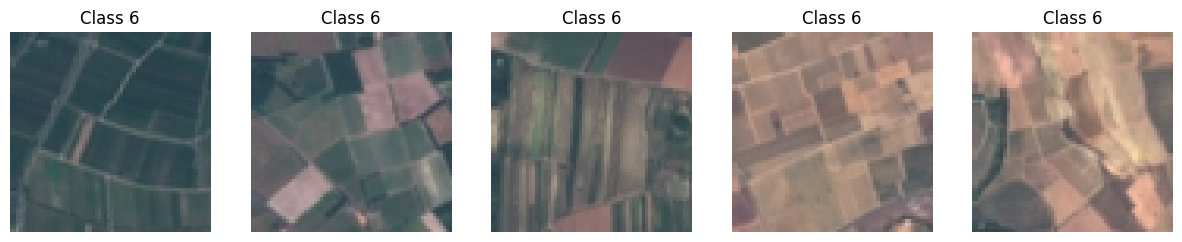

In [55]:
def show_samples(ds, class_label, num_samples=5):
    samples = [example for example in ds['train'] if example['label'] == class_label][:num_samples]
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for idx, sample in enumerate(samples):
        axes[idx].imshow(sample['image'])
        axes[idx].set_title(f"Class {class_label}")
        axes[idx].axis("off")
    plt.show()

print("Samples from Herbaceous vegetation:")
show_samples(ds, class_label=2)

print("Samples from Permanent Crop")
show_samples(ds, class_label=6)